# INIT

In [1]:
import sys
sys.path.append("../POS_tagging/")
sys.path.append("../../../pomegranate/")
sys.path.append(r"C:\Repos\pomegranate")
sys.path.append(r"C:\Repos")
sys.path.append(r"C:/Repos/WhoCell/")
sys.path.append(r"C:/Repos/WhoCell/who_cell/")
sys.path.append(r"C:/Repos/WhoCell/who_cell/models/")
sys.path.append(r"C:/Repos/WhoCell/who_cell/simulation/")
sys.path.append(r"C:\Repos\WhoCell\who_cell\experiments/")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import string

from collections import Counter
from IPython.core.display import HTML
from itertools import chain
from collections import Counter, defaultdict
from helpers import show_model, Dataset
import pandas as pd
import seaborn as sns
import itertools
from functools import reduce


In [4]:
from pomegranate import State, HiddenMarkovModel, DiscreteDistribution

from simulation_for_gibbs import Simulator_for_Gibbs
from gibbs_sampler import GibbsSampler
from experiment_report import ExperimentReport 
from gibbs_experiments import GibbsExperiment

In [5]:
%connect_info
%load_ext autoreload

{
  "shell_port": 58724,
  "iopub_port": 58725,
  "stdin_port": 58726,
  "control_port": 58727,
  "hb_port": 58728,
  "ip": "127.0.0.1",
  "key": "31e62464-7ceaad0160fd0601cbb61e97",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-f78c44d1-e4b2-4ceb-90ad-31893dc793ae.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [6]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [79]:
import warnings
warnings.filterwarnings('ignore')

# load and rearrange data

## read data

In [7]:
tags_path = "data/tags-universal.txt"
data_path = "data/brown-universal.txt"

data = Dataset(tags_path, data_path, train_test_split=0.8)


## stats

In [8]:
length_of_sentences = []
count_of_pos_in_sentence = [] 

for sed_id,sentence in data.training_set : 
    words_no_punctuation = list(filter(lambda x: x not in string.punctuation ,sentence.words))
    tags_no_punctuation = list(filter(lambda x: x not in string.punctuation ,sentence.tags))
    length_of_sentences.append(len(words_no_punctuation))
    count_of_pos_in_sentence.append(Counter(tags_no_punctuation).items())
    
    

Histogram of length of sentences : 


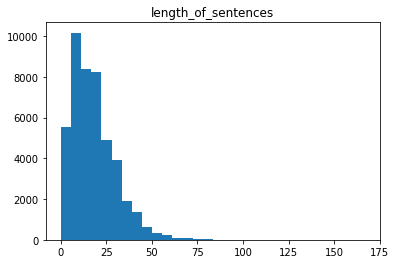

In [9]:
#length_of_sentences
plt.hist(length_of_sentences,bins=30)
plt.title("length_of_sentences")
print("Histogram of length of sentences : ")
plt.show()


In [10]:
np.quantile(length_of_sentences,0.5)

16.0

how unique are the pos ? x axis - number of sentences where the POS occurred x times : 
trimmed in x = 20 


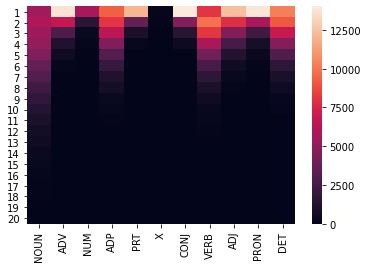

In [11]:
counts_of_pos_in_sentences = Counter(chain(*count_of_pos_in_sentence))
max_count_of_pos = max(map(lambda x:x[1],counts_of_pos_in_sentences.keys())) 
set_of_pos = list(set(map(lambda x:x[0],counts_of_pos_in_sentences.keys())))
_pos_to_idx = {_pos:i for i,_pos in enumerate(set_of_pos)}

multiple_occurrence_matrix = np.zeros((max_count_of_pos,len(set_of_pos)))

for mul_occ,count in counts_of_pos_in_sentences.items() : 
    multiple_occurrence_matrix[mul_occ[1]-1,_pos_to_idx[mul_occ[0]]] = count
    
multiple_occurrence_df = pd.DataFrame(data = multiple_occurrence_matrix,index = range(1,max_count_of_pos+1),columns=set_of_pos)

sns.heatmap(multiple_occurrence_df.head(20))
print("how unique are the pos ? x axis - number of sentences where the POS occurred x times : ")
print("trimmed in x = 20 ")
plt.show()

## build emissions probabilites from training set 

In [12]:
reverse_emms_counts = {} # word => POS mapping 

for _word,_pos in data.training_set.stream() : 
    if _word not in reverse_emms_counts.keys() : 
        reverse_emms_counts[_word] = {_pos:1}
        continue
    if _pos not in reverse_emms_counts[_word] : 
        reverse_emms_counts[_word][_pos] = 1
        continue
    reverse_emms_counts[_word][_pos] += 1


n_of_pos_per_word = [len(poss.items()) for word,poss in reverse_emms_counts.items() ]
print("we counted the number of possible pos per word : ")
print(f"ambiguous per word : {Counter(n_of_pos_per_word)}")

we counted the number of possible pos per word : 
ambiguous per word : Counter({1: 47363, 2: 2939, 3: 203, 4: 25, 5: 6})


In [13]:
emms_counts = {} # word => POS mapping 

for _word,_pos in data.training_set.stream() : 
    if _pos == '.' : continue
    if _pos not in emms_counts.keys() : 
        emms_counts[_pos] = {_word:1}
        continue
    if _word not in emms_counts[_pos] : 
        emms_counts[_pos][_word] = 1
        continue
    emms_counts[_pos][_word] += 1

In [14]:
emms_probs = {word : {pos:(count/sum(poss.values())) for pos,count in poss.items()} for word,poss in emms_counts.items()}


## build starting probabilites

In [15]:
start_count = {pos:0 for pos in set_of_pos}
for idx,sentence in data.training_set : 
    tags_no_punctuation = list(filter(lambda x: x not in string.punctuation ,sentence.tags))
    if len(tags_no_punctuation) == 0 : continue
    _tag = tags_no_punctuation[0]
    start_count[_tag] +=1

start_probs = {pos:count/sum(start_count.values()) for pos,count in  start_count.items()}

## build clean test sets

In [16]:
non_relevent_words = string.punctuation+ '``'+'.'+'--'+"''"+','

In [17]:
# non_relevent_words

In [18]:
test_set_words = [] 
test_set_tags = [] 

for idx,sentence in data.testing_set : 
    clean_tuples = [(word,tag) for word,tag in zip(sentence.words,sentence.tags) if word not in non_relevent_words]
    if len(clean_tuples) < 2 : continue
    test_set_words.append([word for word,tag in clean_tuples ])
    test_set_tags.append([tag for word,tag in clean_tuples ])


# test data and model

## known transitions

In [20]:
transitions_count_tuples = Counter(chain(*[list(zip(sen,sen[1:])) for sen in test_set_tags]))

In [21]:
transitions_count_dict = {}
count_sum = {}
for (_from,_to),count in transitions_count_tuples.items():
    if _from not in transitions_count_dict.keys() : 
        transitions_count_dict[_from] = {_to:count}
        count_sum[_from] = count if _from not in count_sum.keys() else count_sum[_from] + count
        continue
    if _to not in transitions_count_dict[_from].keys():
        transitions_count_dict[_from][_to] = count
        count_sum[_from] = count if _from not in count_sum.keys() else count_sum[_from] + count
        continue
transitions_probs = {k:{kk:(vv/count_sum[k]) for kk,vv in v.items()} for k,v in transitions_count_dict.items()}  
transitions_probs_df = pd.DataFrame(transitions_probs)

C:\Users\Shenorr\AppData\Roaming\Python\Python36\site-packages\pandas\plotting\_matplotlib\core.py:1182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:>

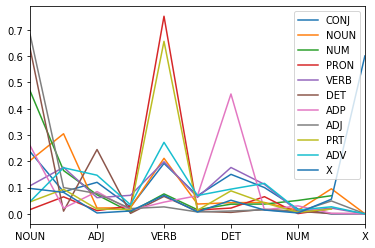

In [22]:
transitions_probs_df.plot()

## build model as pome

In [39]:
def _extrect_states_transitions_dict_from_pome_model( model, states=None):
    if states is None:
        states = model.get_params()['states']

    edges = model.get_params()['edges']
    transition_dict = {}
    final_states = []
    for e in edges:
        if ('start' in states[e[0]].name):
            continue
        if ('end' in states[e[1]].name):
            final_states.append(eval(states[e[0]].name))
            continue

        _from = states[e[0]].name
        _to = states[e[1]].name
        _weight = e[2]

        if _from not in transition_dict.keys():
            transition_dict[_from] = {_to: _weight}
        else:
            transition_dict[_from][_to] = _weight
    return transition_dict, final_states

### build model

In [49]:
states_track = {}

pome_model = HiddenMarkovModel()

for pos,trans in emms_probs.items() : 
    dist = DiscreteDistribution(trans)
    state = State(dist,pos)
    
    pome_model.add_state(state)
    states_track[pos] = state

n_states = len(states_track)
for _from_pos,_from_s in states_track.items():
    for _to_pos,_to_s in states_track.items():
        if _to_pos in transitions_probs[_from_pos].keys():
            pome_model.add_transition(_from_s,_to_s,transitions_probs[_from_pos][_to_pos])

for _pos,_s in states_track.items():
    pome_model.add_transition(pome_model.start,_s,start_probs[_pos])
    
pome_model.bake()

### fit model

In [25]:
test_set_words_no_unknowns = [[(word if word in data.training_set.vocab else None)  for word in sentence] for sentence in test_set_words]
# pome_model.fit(test_set_words_no_unknowns,batches_per_epoch=5,n_jobs = 3)

### build transitions from results

In [26]:
# pome_transitions,_ = _extrect_states_transitions_dict_from_pome_model(pome_model)

In [27]:
# compare_transition(transitions_probs_df,pome_transitions)

# Sampling the known HMM as test set

### code base

In [55]:
def build_pome_for_pos_exp(trnasitions,start_probs,emms_probs) : 

    states_track = {}

    pome_model = HiddenMarkovModel()

    for pos,trans in emms_probs.items() : 
        dist = DiscreteDistribution(trans)
        state = State(dist,pos)

        pome_model.add_state(state)
        states_track[pos] = state

    n_states = len(states_track)
    for _from_pos,_from_s in states_track.items():
        for _to_pos,_to_s in states_track.items():
            if _to_pos in trnasitions[_from_pos].keys():
                pome_model.add_transition(_from_s,_to_s,trnasitions[_from_pos][_to_pos])

    for _pos,_s in states_track.items():
        pome_model.add_transition(pome_model.start,_s,start_probs[_pos])

    pome_model.bake()
    return pome_model

In [75]:
def run_pos_experiment(test_set_words,start_probs,emms_probs,number_of_iters,
                       N,description,known_transitions,title,
                       comper_transitions,comper_transitions_title,state_order_for_plot):
    sampled_transitions, ws, transitions,states_picked_by_w = gs.sample_known_emissions(test_set_words,start_probs,
                                                                                                  emms_probs,number_of_iters,N=N)

    print(description)
    print(f"the format is \"known / {comper_transitions_title}/{title} \") ")
    
    if comper_transitions is None : 
        compare_transition(known_transitions,transitions[-1])
    else : 
        compare_transition(known_transitions,comper_transitions,transitions[-1])

    plot_w_dist(ws,test_set_words)

    plot_states_transitions_as_lines(known_transitions,transitions[-1],state_order_for_plot,f"{title}")
    
    res = {"sampled_transitions":sampled_transitions, 
            "ws":ws, 
            "transitions":transitions,
            "states_picked_by_w":states_picked_by_w}
    return res
    
def plot_w_dist(all_ws,test_set_words) : 
    samples_to_take = np.random.randint(0,len(all_ws),100)
    max_sentence = max(map(len,[test_set_words[i] for i in  samples_to_take]))
    max_sentence = max_sentence if max_sentence > N else N

    w_matrix = np.ones((max_sentence,len(samples_to_take)))*-1 


    for i,i_word in enumerate(samples_to_take) :
        word = test_set_words[i_word]
        w_matrix[0:len(word),i] =  0
        w_matrix[all_ws[-1][i_word],i] =  1

    sns.heatmap(w_matrix)
    plt.show()
    
def plot_states_transitions_as_lines(known,_compr,state_order_for_plot,title) : 
    fig,subs = plt.subplots(2,1)
    _compr_df = pd.DataFrame(_compr)
    known_df = pd.DataFrame(known)
    
    _compr_df = _compr_df[state_order_for_plot].loc[state_order_for_plot]
    known_df = known_df[state_order_for_plot].loc[state_order_for_plot]
    
    known_df.plot(figsize=(8,8),ax=subs[0])
    _compr_df.plot(figsize=(8,8),ax=subs[1])
    
    subs[0].set_title("known")
    subs[1].set_title(title)
    plt.show()

def compare_transition(first_df,second_df,third_df = None):
    if type(first_df) is dict : 
        first_df = pd.DataFrame(first_df)
    if type(second_df) is dict : 
        second_df = pd.DataFrame(second_df)
    
    if third_df is not None : 
        if type(third_df) is dict :
            third_df = pd.DataFrame(third_df)

    second_df = second_df[first_df.columns]
    second_df = second_df.loc[first_df.index]
    
    if third_df is not None : 
        third_df = third_df[first_df.columns]
        third_df = third_df.loc[first_df.index]
    
    if third_df is not None :
        return first_df.round(decimals=3).astype(str) +' / ' + second_df.round(decimals=3).astype(str)+' / ' + third_df.round(decimals=3).astype(str)
        
    comps_plot = first_df.round(decimals=3).astype(str) +' / ' + second_df.round(decimals=3).astype(str)
    return comps_plot

def plot_compersion(first_df_stack,second_df_stack,
                    first_title = 'first',second_title = 'second',
                    third_df_stack = None,third_title = 'third'):
    if type(first_df_stack) is dict : 
        first_df_stack = pd.DataFrame(first_df_stack).stack()
    if type(second_df_stack) is dict : 
        second_df_stack = pd.DataFrame(second_df_stack).stack()

    if third_df_stack is not None : 
        if type(third_df_stack) is dict :
            third_df_stack = pd.DataFrame(third_df_stack).stack()

    if third_df_stack is None : 
        cobined_stack_df = pd.concat([first_df_stack,second_df_stack],axis=1).fillna(0)
        cobined_stack_df = cobined_stack_df.rename(columns={0:first_title,1:second_title})
        
        
        plt.scatter(cobined_stack_df[first_title],cobined_stack_df[second_title])
        plt.xlabel(first_title)
        plt.ylabel(f"{second_title}")
    else : 
        cobined_stack_df = pd.concat([first_df_stack,second_df_stack,third_df_stack],axis=1).fillna(0)
        cobined_stack_df = cobined_stack_df.rename(columns={0:first_title,1:second_title,2:third_title})


        plt.scatter(cobined_stack_df[first_title],cobined_stack_df[second_title])
        plt.scatter(cobined_stack_df[first_title],cobined_stack_df[third_title])
        plt.legend([second_title,third_title])
        plt.xlabel(first_title)
        plt.ylabel(f"{second_title}/{third_title}")
    plt.show()

## create samples

In [61]:
known_model_as_pome = build_pome_for_pos_exp(transitions_probs,start_probs,emms_probs)
sampled_trajs_with_state = known_model_as_pome.sample(n = 10000,length = 30,path=True)
markovien_sentence_words = [[obs for obs in traj[0]] for traj in sampled_trajs_with_state]
markovien_sentence_tags = [[obs.name for obs in traj[1] if 'start' not in obs.name] for traj in sampled_trajs_with_state]

### global params

In [62]:
pc = 0.5
N= 40
number_of_iters = 35

few_observations =  Simulator_for_Gibbs.sample_traj_for_few_obs(pc,markovien_sentence_words)
few_obs_test_set_words = few_observations[0]
few_obs_test_set_ws = few_observations[1]

state_order_for_plot = ['NOUN', 'DET', 'PRON', 'ADJ', 'ADP', 'VERB', 'ADV', 'NUM', 'X', 'PRT','CONJ']
gs = GibbsSampler(2,5)

## learning from P(C) = 1

100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [30:56<00:00, 123.80s/it]


train naive over P(C) = 1 
the format is "known / None/P(C) = 1 ") 


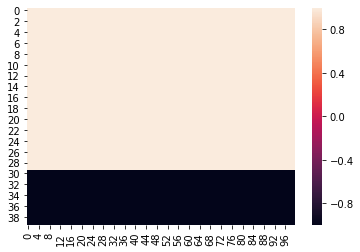

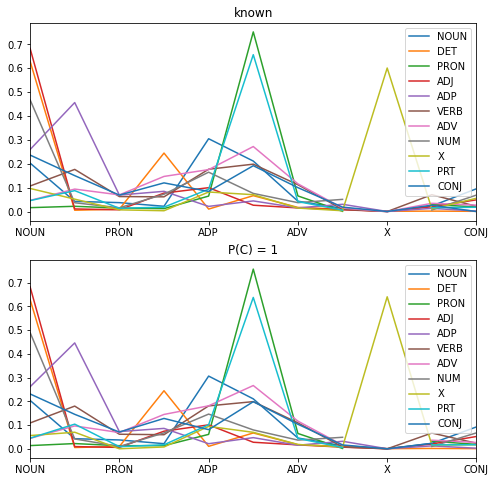

In [80]:
first_experiment_args = {"test_set_words":markovien_sentence_words,
"start_probs":start_probs,
"emms_probs":emms_probs,
"number_of_iters":15,
"N":2,
"description":"train naive over P(C) = 1 ",
"known_transitions":transitions_probs_df,
"comper_transitions":None,
"comper_transitions_title" :None,
"state_order_for_plot":state_order_for_plot,
"title":"P(C) = 1"}
first_experiment_results = run_pos_experiment(**first_experiment_args)

## pass the right length , and learn transitions when some observations are missing  

In [81]:
_known_N = [len(seq) for seq in markovien_sentence_words]


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [28:54<00:00, 115.66s/it]


train naive over P(C) = 0.5 with known N 
the format is "known / None/P(C) = 0.5,known N ") 


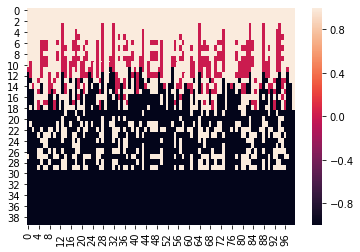

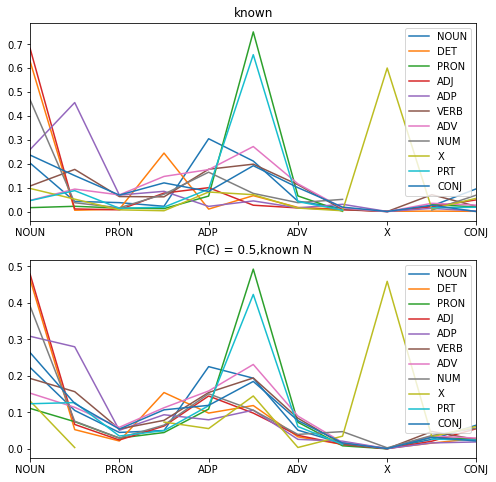

In [82]:
second_experiment_args = {"test_set_words":few_obs_test_set_words,
"start_probs":start_probs,
"emms_probs":emms_probs,
"number_of_iters":15,
"N":_known_N,
"description":"train naive over P(C) = 0.5 with known N ",
"known_transitions":transitions_probs_df,
"comper_transitions":None,
"comper_transitions_title" :None,
"state_order_for_plot":state_order_for_plot,
"title":"P(C) = 0.5,known N"}
second_experiment_results = run_pos_experiment(**second_experiment_args)

## compare to naive - learn using regular model on few observations 

100%|███████████████████████████████████████████████████████████████████████████████| 15/15 [1:16:41<00:00, 306.78s/it]


reguler over few observations 
the format is "known / None/reguler ") 


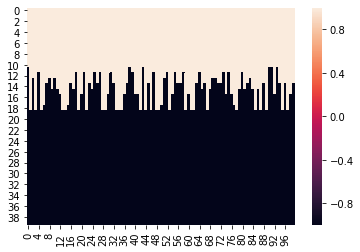

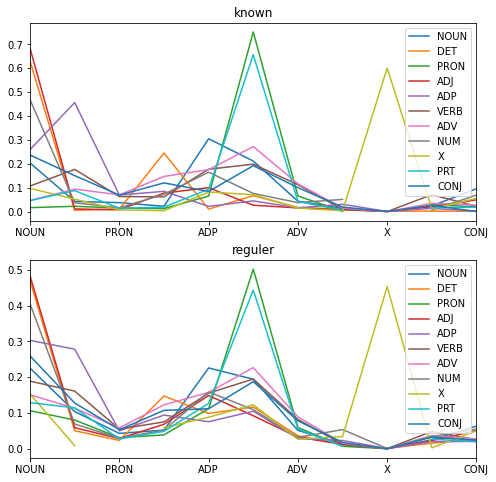

In [83]:
third_experiment_args = {"test_set_words":few_obs_test_set_words,
"start_probs":start_probs,
"emms_probs":emms_probs,
"number_of_iters":15,
"N":2,
"description":"reguler over few observations ",
"known_transitions":transitions_probs_df,
"comper_transitions":None,
"comper_transitions_title" :None,
"state_order_for_plot":state_order_for_plot,
"title":"reguler"}
third_experiment_results = run_pos_experiment(**third_experiment_args)

# compare all results

## compare experiments transitions using line plots

In [85]:
all_states = {}
all_states["stationary"] =  {state:count/sum(Counter(chain(*test_set_tags)).values()) for state,count  in Counter(chain(*test_set_tags)).items()}

CONJ : 


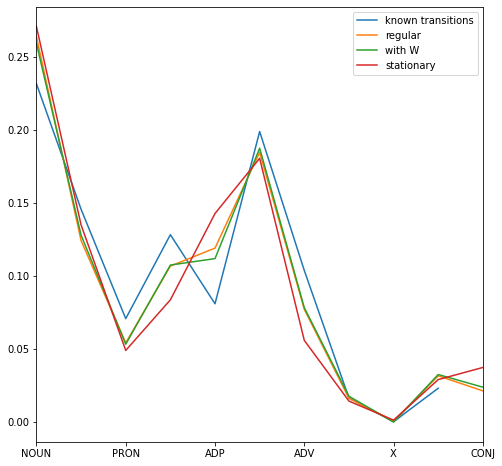

NOUN : 


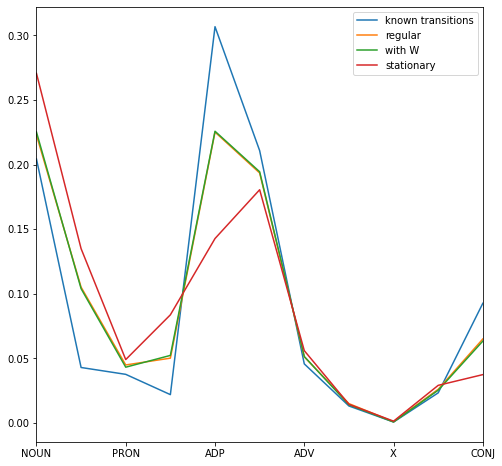

NUM : 


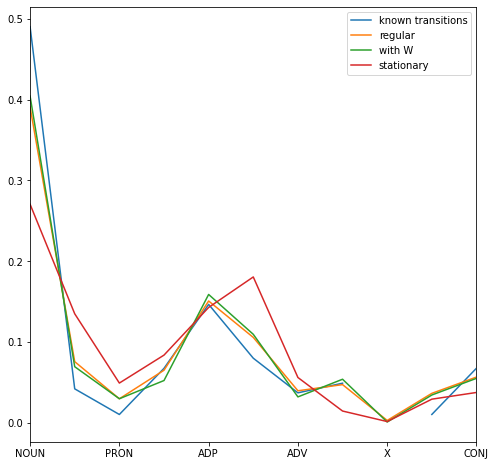

PRON : 


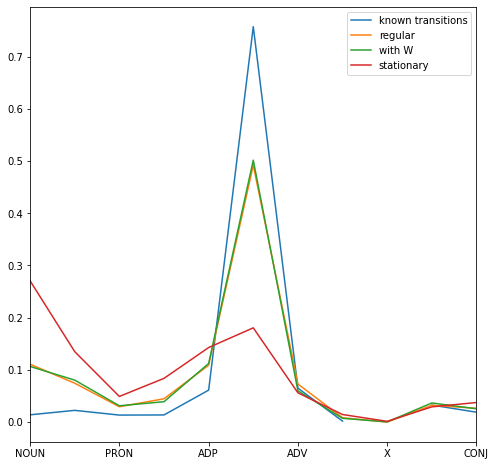

VERB : 


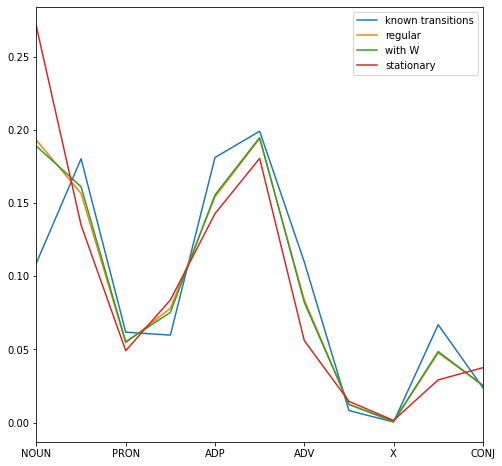

DET : 


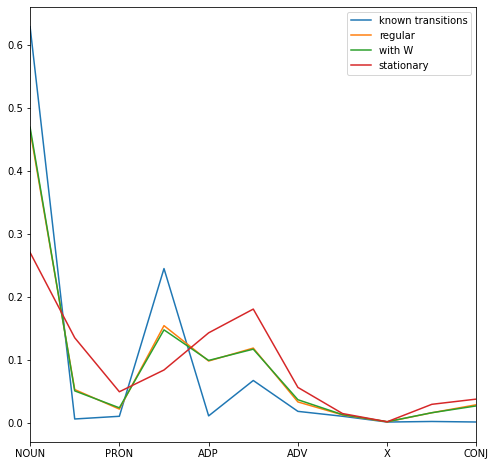

ADP : 


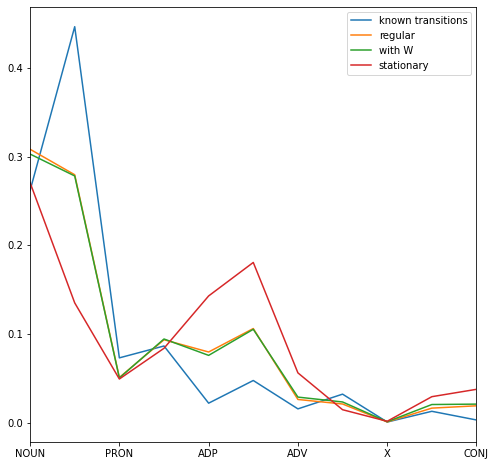

ADJ : 


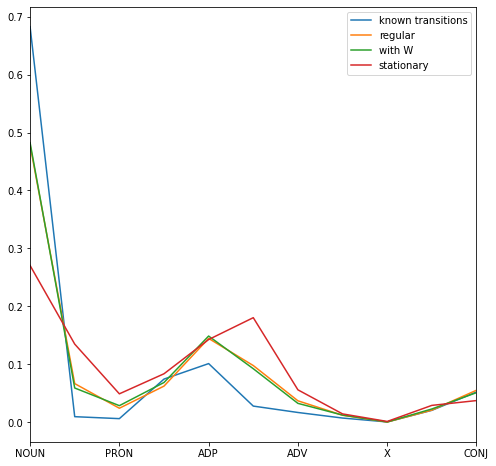

PRT : 


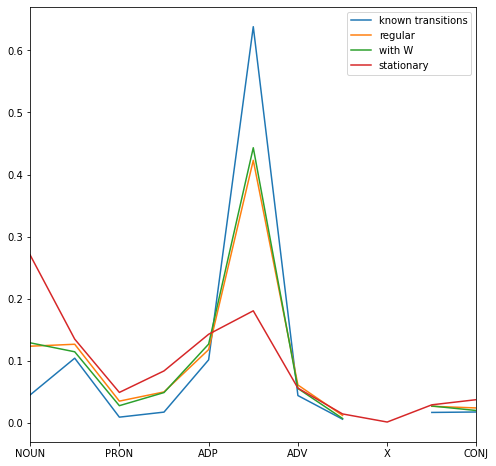

ADV : 


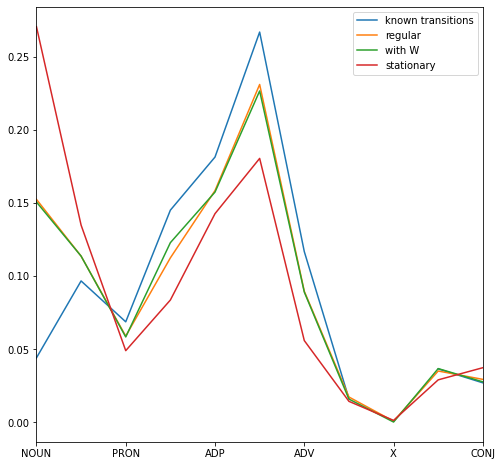

X : 


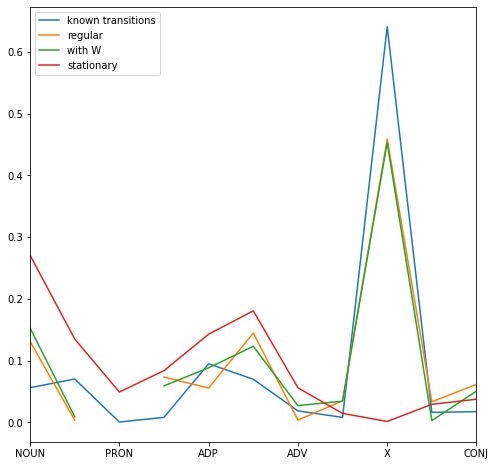

In [86]:
def compre_transitions_line_plots(original_transitions,first_comprr,second_comprr,
                                 states_to_comapre,stationary_transitions,order= ['NOUN', 'DET', 'PRON', 'ADJ', 'ADP', 'VERB', 'ADV', 'NUM', 'X', 'PRT',
                                 'CONJ'],
                                 first_comprr_name = "regular",second_comprr_name = 'with W') : 

    for state in states_to_comapre :
        fig,sub = plt.subplots(1,figsize=(8,8))
        
        print(f"{state} : ")
        
        pd.DataFrame(original_transitions)[state].loc[order].plot(ax = sub)
        pd.DataFrame(first_comprr)[state].loc[order].plot(ax = sub)
        pd.DataFrame(second_comprr)[state].loc[order].plot(ax = sub)
        pd.DataFrame(stationary_transitions).loc[order].plot(ax = sub)
        plt.legend(['known transitions',f'{first_comprr_name}',f'{second_comprr_name}',"stationary"])
        plt.show()

compre_transitions_line_plots(first_experiment_results['transitions'][-1],second_experiment_results['transitions'][-1],
                              third_experiment_results['transitions'][-1],
                             transitions_probs_df.columns.to_list(),all_states)

## per iter distance

In [95]:
# def extrect_observed_transitions(ws,_states_picked):
#     real_walks = [] 
#     for w,states_walk in zip(ws,_states_picked) : 
#         real_transitions = [(states_walk[_f],states_walk[_t]) for _f,_t in zip(range(len(w)),range(1,len(w))) if (w[_t]-w[_f]) == 1]
#         real_walks.append(real_transitions)

#     real_transition_dict = {}
#     for (_from,_to),count in  Counter(itertools.chain(*real_walks)).items() :
#         if _from not in real_transition_dict.keys() :
#             real_transition_dict[_from] = {_to:count}
#         else : 
#             real_transition_dict[_from][_to] = count
            
#     real_transition_dict_normalized = {_from:{__from:_count/sum(to.values()) for __from,_count in to.items()} for _from,to in real_transition_dict.items()}
#     return real_transition_dict_normalized

# all_transitions_knownN_observed_only = [extrect_observed_transitions(ws_list,_states_picked) for ws_list,_states_picked in zip(all_ws_knownN,_states_picked_by_w)]

In [88]:
er = ExperimentReport()

In [89]:
# transitions_results_list = [all_transitions,all_transitions_knownN,all_transitions_fixed_N,all_transitions_few_fixed_N,all_transitions_few_regular] 
# w_results_list = [all_ws,all_ws_knownN,all_ws_fixed_N,all_ws_few_fixed_N,all_ws_few_regular] 
# experiments_name_list = ["P(C) = 1" ,f"P(C) = {pc} \ right N as prior",f"P(C) =  1 , constent N={N} ",f"P(C) =  {pc} , constent N ",f"P(C) =  {pc} , regular hmm "]
# global_params = [pc,N] 

In [90]:
transitions_results_list = [first_experiment_results['transitions'],second_experiment_results['transitions'],third_experiment_results['transitions']]
w_results_list = [first_experiment_results['ws'],second_experiment_results['ws'],third_experiment_results['ws']]
experiments_name_list = [first_experiment_args['title'],second_experiment_args['title'],third_experiment_args['title']]
global_params = [pc,N] 

In [91]:
__l1_distance = lambda dist,state,known : abs(dist[state]-known) if state in dist.keys() else known
__cross_entropy_distance = lambda dist,state,known : -1*known*np.log(dist[state]) if state in dist.keys() else (-1*known*np.log(0.0001))

_l1_distance = lambda known_dist,comp_dist:sum(([__l1_distance(comp_dist,state,prob) for state,prob in known_dist.items()]))
_cross_entropy_distance = lambda known_dist,comp_dist:sum([__cross_entropy_distance(comp_dist,state,prob) for state,prob in known_dist.items()])

l1_distance = lambda known_trns,comp_trans : np.mean([_l1_distance(dist,comp_trans[state]) for state,dist in known_trns.items()])
cross_entropy_distance = lambda known_trns,comp_trans : np.mean([_cross_entropy_distance(dist,comp_trans[state]) for state,dist in known_trns.items()])


In [92]:
_trajectory_prob = lambda traj,model_trans:reduce(lambda x,y:x*y,[model_trans[_f][_t] for _f,_t in zip(traj,traj[1:])])

original_model = build_pome_for_pos_exp(transitions_probs,start_probs,emms_probs)
sampled_trajs = original_model.sample(n = 300,length = N,path=True)
sampled_trajs_states = [[obs.name for obs in traj[1] if 'start' not in obs.name] for traj in sampled_trajs]
known_probs = [_trajectory_prob(traj,transitions_probs) for traj in sampled_trajs_states]

def kl_distance_transitions(comp_transitions,sampled_trajs_states,known_probs) : 
    comp_probs = [_trajectory_prob(traj,comp_transitions) for traj in sampled_trajs_states]
    return sum([np.log(known/comp)*known for known,comp in zip(known_probs,comp_probs)])
    
    

In [93]:
%autoreload 2
original_model = build_pome_for_pos_exp(transitions_probs,start_probs,emms_probs)

external_samples = original_model.sample(300,length=70) 
all_kl_results = {}
all_l1_results = {}
all_ce_results = {}
for _trans_list,exp_name in zip(transitions_results_list,experiments_name_list) : 
    kl_dist = [kl_distance_transitions(_t,sampled_trajs_states,known_probs) for _t in _trans_list]
    l1_dist = [l1_distance(transitions_probs,_t) for _t in _trans_list]
    ce_dist = [cross_entropy_distance(transitions_probs,_t) for _t in _trans_list]
    
    all_kl_results[exp_name] = kl_dist
    all_l1_results[exp_name] = l1_dist
    all_ce_results[exp_name] = ce_dist



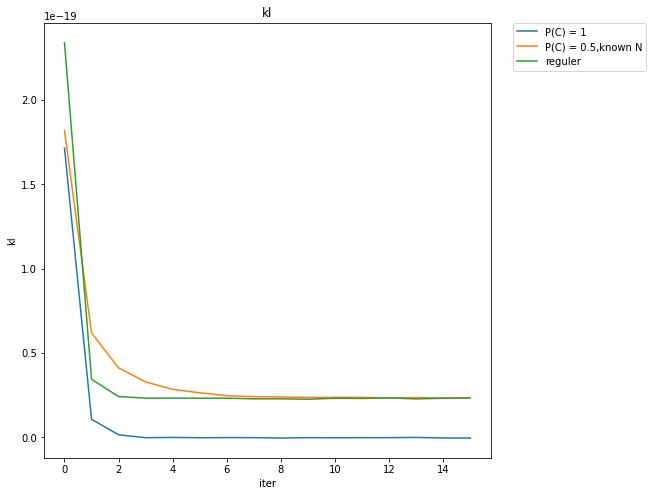

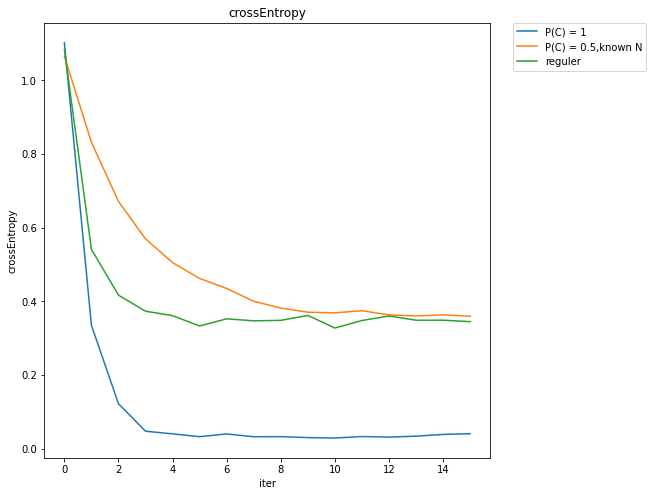

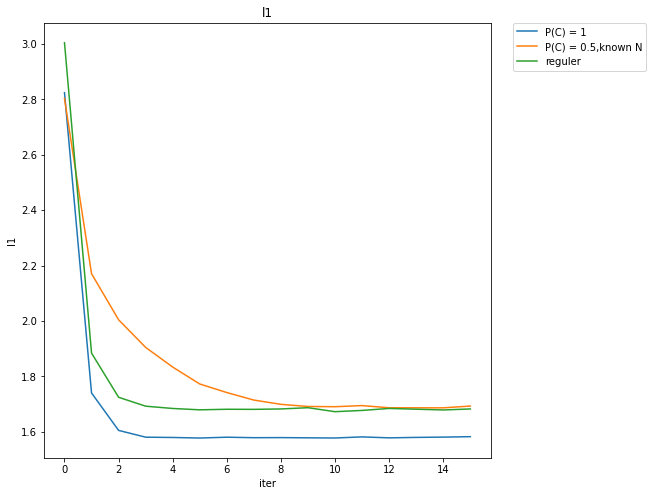

In [94]:


for all_results,name in zip([all_kl_results,all_l1_results,all_ce_results],['kl','crossEntropy','l1']) : 
    fig, sub = plt.subplots(1,1,figsize=(8, 8))
    model_results_df = pd.DataFrame(all_results)

    sns.lineplot(data=model_results_df, ax=sub, legend='full', dashes=False)
    sub.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    sub.set_title(f"{name}")
    sub.set_xlabel("iter")
    sub.set_ylabel(f"{name}")

    plt.subplots_adjust(hspace=0.8)
    plt.subplots_adjust(wspace=0.8)

    plt.show()

## Ws

In [ ]:
few_seq_of_tags = [[seq[i] for i in ws ] for ws,seq in zip(few_obs_test_set_tags,test_set_tags)]
tags_from_sampler = _states_picked_by_w[-1]
tags_random_allocation =[[seq[i] for i in np.random.randint(0,len(seq),size=len(ws)) ] for ws,seq in zip(few_obs_test_set_tags,test_set_tags)]

distance_func =lambda a,b: sum(map(lambda x:int(x[0]!=x[1]) ,zip(a,b))) / len(a)

In [ ]:
random_dists = [distance_func(_rand,known) for _rand,known in  zip(tags_random_allocation,few_seq_of_tags)]
sapmled_dists = [distance_func(_sampled,known) for _sampled,known in  zip(tags_from_sampler,few_seq_of_tags)]


In [ ]:

plt.hist(random_dists,bins=50)
plt.hist(sapmled_dists,bins=50)
plt.title("Normalized Hamming distance per sentence")
plt.legend(["distance from random allocation","distance from W"])
plt.show()